## Семинар. Градиентный бустинг

<img src="img/sem_level_wise.jpg" height=70% width=70%>

**Level wise** - XGBoost. Стратегия - увеличение сложности модели при помощи углубления дерева, поддерживая его в сбалансированном состоянии. Каждый узел разбивает данные, причем приоритет узлам ближе к корню дерева.

Обычно такая стратегия построения дерева хорошо работает на более маленьких датасетах, где leaf wise подход приводит к переобучению.

<img src="img/sem_leaf_wise.jpg" height=70% width=70%>

**Leaf wise** - в LGBM. Стратегия - наращивание дерева, разбивая данные в узлах, которые дают наибольшие изменения функции потерь. На больших датасетах такой подход стабильно успешен (https://researchcommons.waikato.ac.nz/handle/10289/2317), давая при этом значительный прирост к скорости обучения.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from datetime import datetime 
from pandas import Series, DataFrame 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
 
import lightgbm as lgb 
import xgboost as xgb 

%matplotlib inline

In [2]:
!conda install -c conda-forge lightgbm

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
/ 

Датасет для семинара - https://www.kaggle.com/wenruliu/adult-income-dataset

### Постановка задачи

Необходимо сравнить LightGBM и XGBoost по двум критериям:
1. Качество.
2. Время работы.

Отдельно стоит оговорить то, что сравнивать качество нужно между моделями, которые имеют сопоставимую сложность.
Поэтому:

1. Ограничим глубину деревьев до 7
2. Максимальное количество итераций - 50 (маленький датасет).

In [2]:
data = pd.read_csv('./data/adult.csv') 

data.columns = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education_num',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital_gain',
    'capital_loss',
    'hours_per_week',
    'native_country',
    'income'
] 

data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Таргет в нашем датасете - income, его необходимо закодировать

In [3]:
label_encoder = LabelEncoder()

data.income = label_encoder.fit_transform(data.income)

data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [4]:
data.income.unique()

array([0, 1])

In [5]:
data.income.value_counts()

0    37155
1    11687
Name: income, dtype: int64

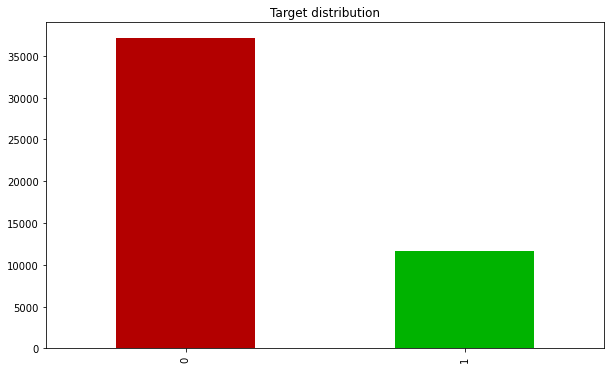

In [17]:
my_colors = [(0.7,0,0), (0, 0.7, 0)]
data.income.value_counts().plot(kind="bar", figsize=(10,6), color=my_colors)
plt.title("Target distribution")
plt.show()

In [18]:
ohe_cols = [
    'workclass',
    'education',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country'
]

ohe_dfs = []

for ohe_col in ohe_cols:
    feat_df = pd.get_dummies(data[ohe_col])
    ohe_dfs.append(feat_df)

data = data.drop(ohe_cols, axis=1)
data = pd.concat([data] + ohe_dfs, axis=1)

In [19]:
 _, i = np.unique(data.columns, return_index=True) 
data = data.iloc[:, i] 

In [20]:
X = data.drop('income',axis=1) 
y = data.income
y = y.fillna(y.mode()[0])
 
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

## XGBoost

In [25]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test)

parameters = {
    'max_depth': 7,
    'eta': 1,
    'objective': 'binary:logistic',
    'learning_rate': 0.05
}

num_round = 50

start = datetime.now() 
xg = xgb.train(parameters, dtrain, num_round) 
stop = datetime.now()

execution_time_xgb = stop - start 
execution_time_xgb

y_pred = xg.predict(dtest) 
y_pred = [1 if y_i >= 0.5 else 0 for y_i in y_pred]

accuracy_xgb = accuracy_score(y_test, y_pred) 
accuracy_xgb

[16:22:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8592097181464546

## LightGBM

In [26]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

param = {
    'num_leaves': 150,
    'objective':'binary',
    'metric': 'binary_logloss',
    'max_depth': 7,
    'learning_rate': 0.05,
    'max_bin': 200
}

num_round=50

start = datetime.now()
lgbm = lgb.train(param, train_data, num_round)
stop = datetime.now()

execution_time_lgbm = stop - start

y_pred_2 = lgbm.predict(X_test)
y_pred_2 = [1 if y_i >= 0.5 else 0 for y_i in y_pred_2]
accuracy_lgbm = accuracy_score(y_test, y_pred_2)
accuracy_lgbm

[LightGBM] [Info] Number of positive: 8146, number of negative: 26043
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 34189, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238264 -> initscore=-1.162222
[LightGBM] [Info] Start training from score -1.162222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

0.8592097181464546

In [27]:
comparison_dict = {
    "model_type": ("xgb", "lgb"),
    "accuracy": (accuracy_xgb, accuracy_lgbm),
    "exec_time": (execution_time_xgb, execution_time_lgbm)
}

result = pd.DataFrame(comparison_dict)
result

,model_type,accuracy,exec_time
0,xgb,0.85921,0 days 00:00:04.501661
1,lgb,0.85921,0 days 00:00:00.310588


## Вывод

LightGBM показал очень сопоставимый уровень качества, имея при этом значительный выигрыш по скорости по сравнению с XGBoost.

## Основные преимущества LightGBM

* Большая скорость обучения и предсказания
* Более эффективное использование памяти
* Обладает наилучшим соотношением качество/скорость работы
* Совместимо с большими датасетами

## Ключевые параметры

* num_leaves - Количество листьев в одном дереве, default = 31
* max_depth - Максимальная глубина дерева
* min_data_in_leaf - Минимальное количество объектов в листе
* feature_fraction - Доля признаков, которые берутся в расчет при построении дерева, default = 1
* bagging_fraction - Доля объектов, которые используются при обучении, default = 1
* min_gain_to_split - Минимальный прирост критерия для совершения сплита, default = 0.1
* max_bin - Максимальное количество бинов, используемых для разбиения по значениям.